In [1]:
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
%env TF_GPU_ALLOCATOR=cuda_malloc_async

env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [1]:
import os
print(os.environ["LD_LIBRARY_PATH"])

:/home/nkspartan/miniconda3/envs/tf-gpu/lib/:/home/nkspartan/miniconda3/envs/tf-gpu/lib/


In [25]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt

from keras import Sequential, models, Input
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, GaussianNoise
from keras.optimizers import SGD, Adam

In [2]:
from tensorflow.python.client import device_lib

#print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2022-10-19 00:38:46.269164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 00:38:46.286729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 00:38:46.299153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 00:38:46.299361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Read the csv dataset to get the values for stage and discharge of the images

In [3]:
df = pd.read_csv("../../../dataset/2012_2019_PlatteRiverWeir_features_merged_all.csv")
df.head()

,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df = df[["Filename", "Stage", "Discharge", 'SensorTime']]

In [5]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year

### Scale the data

In [6]:
from sklearn.preprocessing import StandardScaler
from joblib import load

#scaler = StandardScaler()
scaler = load('../std_scaler.joblib')

In [7]:
df[["Stage", "Discharge"]] = scaler.fit_transform(df[["Stage", "Discharge"]])
df


,Filename,Stage,Discharge,SensorTime,Year
0,StateLineWeir_20120609_Farrell_001.jpg,0.138117,-0.046094,2012-06-09 13:15:00,2012
1,StateLineWeir_20120609_Farrell_002.jpg,0.138117,-0.046094,2012-06-09 13:15:00,2012
2,StateLineWeir_20120609_Farrell_003.jpg,0.100875,-0.082160,2012-06-09 13:45:00,2012
3,StateLineWeir_20120609_Farrell_004.jpg,0.076046,-0.104807,2012-06-09 14:45:00,2012
4,StateLineWeir_20120609_Farrell_005.jpg,0.076046,-0.104807,2012-06-09 15:45:00,2012
...,...,...,...,...,...
42054,StateLineWeir_20191011_Farrell_409.jpg,-0.420526,-0.450369,2019-10-11 09:00:00,2019
42055,StateLineWeir_20191011_Farrell_410.jpg,-0.420526,-0.450369,2019-10-11 10:00:00,2019
42056,StateLineWeir_20191011_Farrell_411.jpg,-0.420526,-0.450369,2019-10-11 11:00:00,2019
42057,StateLineWeir_20191011_Farrell_412.jpg,-0.420526,-0.450369,2019-10-11 12:00:00,2019


In [8]:
from joblib import dump
#dump(scaler, 'std_scaler.joblib')

## Create the dataset pipeline

In [9]:
#IMG_SIZE = 224
IMG_SIZE = 512
BATCH_SIZE = 32

In [10]:
from glob import glob

def make_dataset(path, batch_size, df, seed=None, years=False):
  np.random.seed(seed)

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    # image augmentation
    #image = random_image_augmentation(image, 0.7)

    image = tf.cast(image, tf.float32)
    image /= 255
    return image

  def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

  filenames = glob(path + '/*')
  train_files = []
  val_files = []
  test_files = []
  
  if years:
    files = set(df[(df.Year >= 2012) & (df.Year <= 2016)].Filename.values)
    train_files = [file for file in filenames if file.split('/')[-1] in files]
    print(len(train_files))

    files = set(df[(df.Year >= 2017) & (df.Year <= 2017)].Filename.values)
    val_files = [file for file in filenames if file.split('/')[-1] in files]
    print(len(val_files))

    files = set(df[(df.Year >= 2018) & (df.Year <= 2019)].Filename.values)
    test_files = [file for file in filenames if file.split('/')[-1] in files]
    print(len(test_files))
  else:
    # make train, val and test splits of the dataset (70%, 10%, 20% split)
    split1 = int(0.7 * len(filenames))
    split2 = int(0.8 * len(filenames))

    np.random.shuffle(filenames)
    train_files = filenames[:split1] # up to split 1 (ex 70%)
    val_files = filenames[split1:split2] # from ex. 70% to 80%
    test_files = filenames[split2:] # from ex. 80% until the end

  # create stage values
  stage_train_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in train_files]
  stage_val_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in val_files]
  stage_test_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in test_files]

  # create discharge values
  discharge_train_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in train_files]
  discharge_val_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in val_files]
  discharge_test_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in test_files]

  # join stage and discharge values
  stage_discharge_train_values = [[np.squeeze(s), np.squeeze(d)] for s, d in zip(stage_train_values, discharge_train_values)]
  stage_discharge_val_values = [[np.squeeze(s), np.squeeze(d)] for s, d in zip(stage_val_values, discharge_val_values)]
  stage_discharge_test_values = [[np.squeeze(s), np.squeeze(
      d)] for s, d in zip(stage_test_values, discharge_test_values)]

  # create images dataset (train, val, test)
  filenames_train_ds = tf.data.Dataset.from_tensor_slices(train_files)
  filenames_val_ds = tf.data.Dataset.from_tensor_slices(val_files)
  filenames_test_ds = tf.data.Dataset.from_tensor_slices(test_files)

  images_train_ds = filenames_train_ds.map(parse_image, num_parallel_calls=8)
  images_val_ds = filenames_val_ds.map(parse_image, num_parallel_calls=8)
  images_test_ds = filenames_test_ds.map(parse_image, num_parallel_calls=8)

  # create stage and discharge dataset (train, val, test)
  stage_discharge_train_ds = tf.data.Dataset.from_tensor_slices(stage_discharge_train_values)
  stage_discharge_val_ds = tf.data.Dataset.from_tensor_slices(stage_discharge_val_values)
  stage_discharge_test_ds = tf.data.Dataset.from_tensor_slices(
      stage_discharge_test_values)

  # create tensorflow dataset of images and values (train, val, test)
  train_ds = tf.data.Dataset.zip((images_train_ds, stage_discharge_train_ds))
  train_ds = configure_for_performance(train_ds)
  val_ds = tf.data.Dataset.zip((images_val_ds, stage_discharge_val_ds))
  val_ds = configure_for_performance(val_ds)
  test_ds = tf.data.Dataset.zip((images_test_ds, stage_discharge_test_ds))
  test_ds = configure_for_performance(test_ds)

  return train_ds, len(train_files), val_ds, len(val_files), test_ds, len(test_files)

In [11]:
path = "../../../dataset/images"

train_ds, train_size, val_ds, val_size, test_ds, test_size = make_dataset(path, BATCH_SIZE, df, 10, True)

21421
7390
13248


2022-10-19 00:41:39.890472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 00:41:39.890687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 00:41:39.890832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 00:41:39.891179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 00:41:39.891330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [12]:
input_shape = 0
output_shape = 0

for image, stage_discharge in train_ds.take(1):
    print(image.numpy().shape)
    print(stage_discharge.numpy().shape)

    input_shape = image.numpy().shape[1:]
    output_shape = stage_discharge.numpy().shape[1:]

(32, 512, 512, 3)
(32, 2)


In [13]:
print(input_shape)
print(output_shape)

(512, 512, 3)
(2,)


## Check images

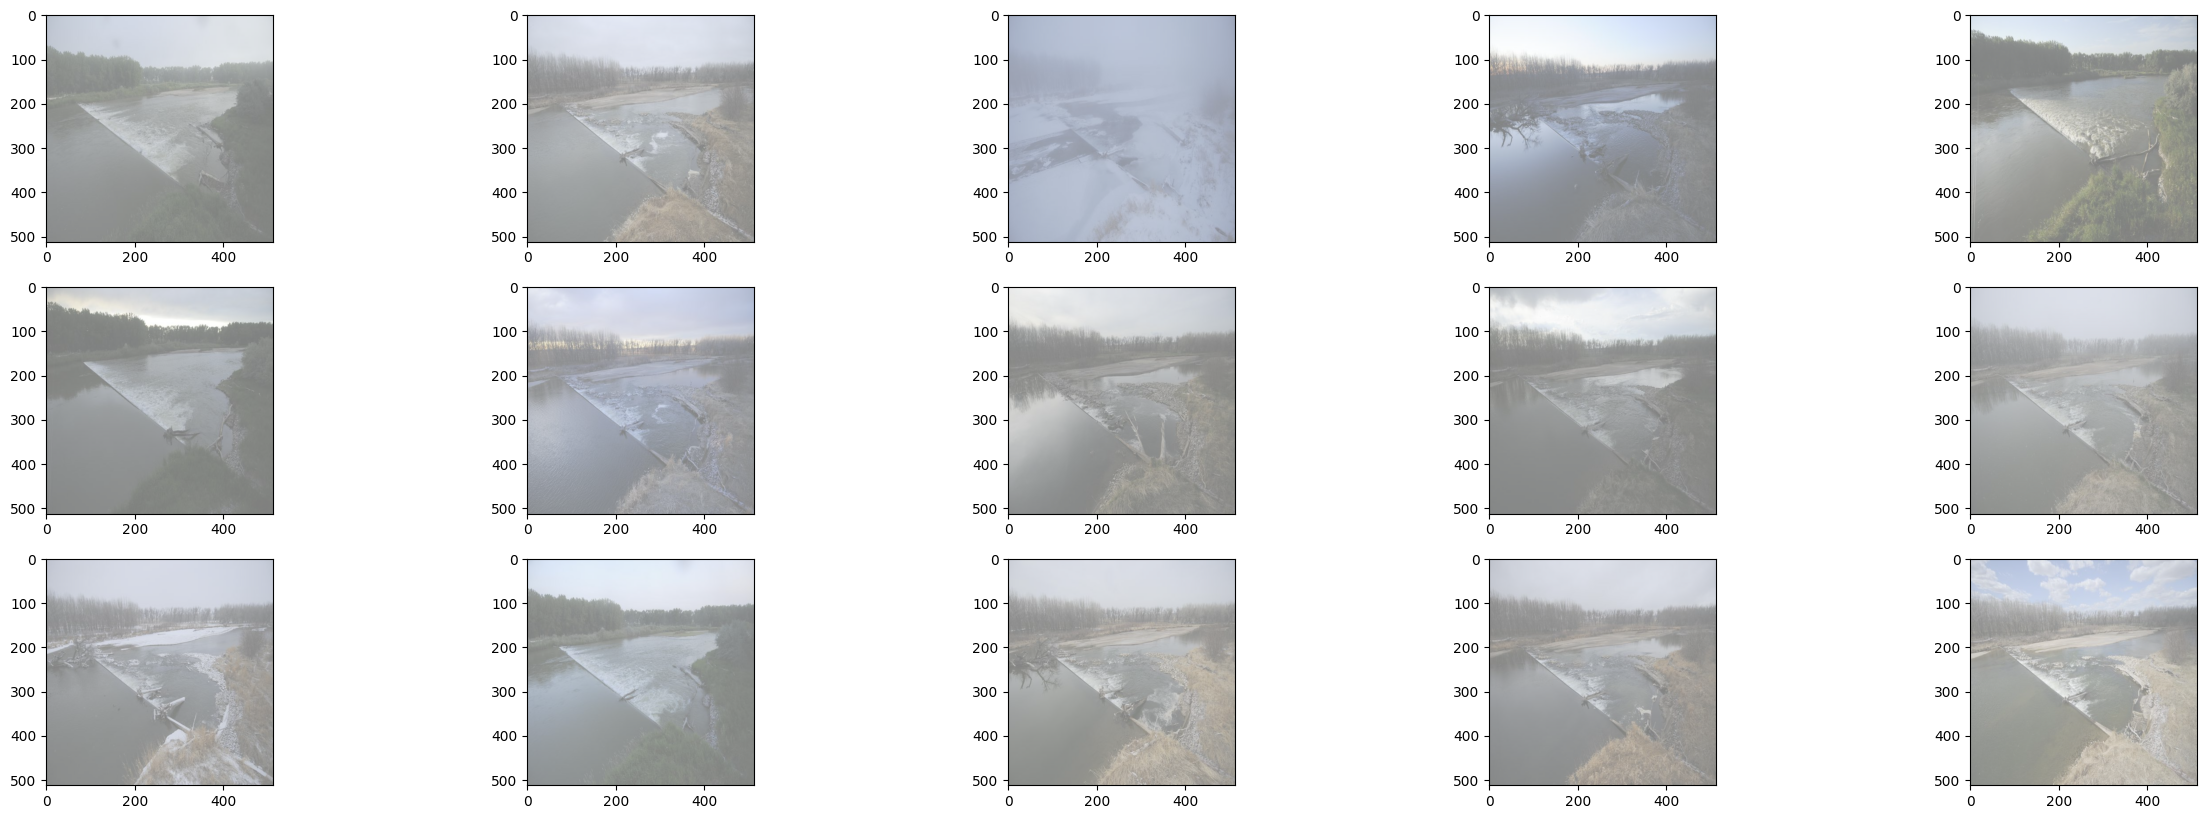

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(30, 10))

for image, stage_discharge in test_ds.take(1):
    images = image[:15]
    for img, ax in zip(images, ax.flatten()):
        img = img.numpy()
        img = img / 2 + 0.5     # unnormalize
        ax.imshow(img)

plt.show()

## Create model

In [49]:
def create_model(input_shape, output_shape, transfer_learning=False):
    model = Sequential()

    if (transfer_learning == True):
        base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                weights='imagenet',
                                                input_shape=input_shape)
        base_model.trainable = False
        base_model._name = 'base_model_MobileNet'

        model.add(base_model)
        model.add(Dropout(0.6))
        model.add(GlobalAveragePooling2D())

        model.add(Dense(512, activation='tanh'))
        model.add(Dense(256, activation='tanh'))
        model.add(Dense(256, activation='tanh'))
        model.add(Dense(64, activation='tanh'))
    else:
        model.add(Input(shape=input_shape))

        model.add(Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', activation=LeakyReLU()))
        model.add(MaxPooling2D(pool_size=(4, 4)))

        model.add(Conv2D(64, kernel_size=(4, 4), strides=(2, 2), activation=LeakyReLU(), padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, kernel_size=(3, 3), activation=LeakyReLU(0.2), padding='same'))
        #model.add(AveragePooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

        model.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
        model.add(AveragePooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(128, activation='tanh'))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='tanh'))
        model.add(Dense(32, activation='tanh'))
        model.add(Dense(32, activation='tanh'))
        
    model.add(Dense(output_shape, activation='linear')) # linear regression output layer

    return model


In [50]:
model = create_model(input_shape, output_shape[0], False)

In [51]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 256, 256, 64)      3136      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        65600     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 32)        18464     
                                                                 
 conv2d_28 (Conv2D)          (None, 14, 14, 32)       

In [52]:
def compile_model(loss_func, optimizer, metrics=["accuracy"]):
    model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)

In [53]:
sgd = SGD(learning_rate=0.01, decay=1e-4, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=1e-3, decay=1e-3 / 200)

compile_model('mse', adam,  [
              'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])


In [54]:
def fit_model(training_values, validation_values=None, epochs=10, steps=32, val_steps=32, callbacks=[]):
    return model.fit(training_values, validation_data=validation_values, epochs=epochs, steps_per_epoch=steps, validation_steps=val_steps, callbacks=callbacks)

In [55]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/cnn_v10_years_logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/cnn_best_weights_v10_v2_years.hdf5",
                               monitor='val_mse',
                               verbose=1,
                               save_best_only=True)


In [56]:
# batch_size = 0 because we already have batch size in tf dataset
model_h = fit_model(train_ds, val_ds, epochs=15, steps=np.ceil(train_size / BATCH_SIZE), val_steps=np.ceil(val_size / BATCH_SIZE), callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/15
669/670 [============================>.] - ETA: 0s - loss: 0.2141 - mse: 0.2141 - rmse: 0.4627 - mae: 0.2438 - mape: 89.2689
Epoch 1: val_mse improved from inf to 0.06308, saving model to model_weights/cnn_best_weights_v10_v2_years.hdf5
670/670 [==============================] - 76s 112ms/step - loss: 0.2140 - mse: 0.2140 - rmse: 0.4626 - mae: 0.2437 - mape: 89.2294 - val_loss: 0.0631 - val_mse: 0.0631 - val_rmse: 0.2512 - val_mae: 0.1881 - val_mape: 54.1744
Epoch 2/15
669/670 [============================>.] - ETA: 0s - loss: 0.0210 - mse: 0.0210 - rmse: 0.1451 - mae: 0.1011 - mape: 50.4456
Epoch 2: val_mse improved from 0.06308 to 0.03073, saving model to model_weights/cnn_best_weights_v10_v2_years.hdf5
670/670 [==============================] - 75s 112ms/step - loss: 0.0210 - mse: 0.0210 - rmse: 0.1450 - mae: 0.1011 - mape: 50.4243 - val_loss: 0.0307 - val_mse: 0.0307 - val_rmse: 0.1753 - val_mae: 0.1252 - val_mape: 40.2458
Epoch 3/15
669/670 [============================

## Evaluate model

In [57]:
print(date_actual)

20221019-005607


In [78]:
best_model = models.load_model(f'model_weights/cnn_best_weights_v10_v2_years.hdf5')

In [79]:
def evaluate_model(model, test_values, steps):
  score = model.evaluate(test_values, steps=steps)
  return score

In [80]:
test_loss, test_mse, test_rmse, test_mae, test_mape = evaluate_model(best_model, test_ds, steps=np.ceil(test_size / BATCH_SIZE))

414/414 [==============================] - 25s 61ms/step - loss: 0.0434 - mse: 0.0434 - rmse: 0.2082 - mae: 0.1416 - mape: 184.7284


In [81]:
for image, stage_discharge in test_ds.take(1):
	predictions = best_model.predict(x=image)

	stage_discharge_test_values = stage_discharge[:2].numpy()
	predictions_values = predictions[:2]
	
	diff = predictions_values.flatten() - stage_discharge_test_values.flatten()
	percentDiff = (diff / stage_discharge_test_values.flatten()) * 100
	absPercentDiff = np.abs(percentDiff)
	# compute the mean and standard deviation of the absolute percentage
	# difference
	mean = np.mean(absPercentDiff)
	std = np.std(absPercentDiff)
	# finally, show some statistics on our model
	print(mean)
	print(std)

	stage_discharge_test_values = stage_discharge[:10]
	predictions_values = predictions[:10]

	for i in range(len(stage_discharge_test_values.numpy())):
		print(f"pred stage: {scaler.inverse_transform(predictions_values)[i][0]}, actual stage: {scaler.inverse_transform(stage_discharge_test_values)[i][0]}")
		print(f"pred discharge: {scaler.inverse_transform(predictions_values)[i][1]}, actual discharge: {scaler.inverse_transform(stage_discharge_test_values)[i][1]}")

1/1 [==============================] - 0s 109ms/step
11.291423742541342
13.68976189883838
pred stage: 2.3655991554260254, actual stage: 2.09
pred discharge: 138.3881378173828, actual discharge: 123.0
pred stage: 2.2583847045898438, actual stage: 2.23
pred discharge: 157.4553985595703, actual discharge: 189.0
pred stage: 3.0246386528015137, actual stage: 3.25
pred discharge: 1019.135498046875, actual discharge: 1240.0
pred stage: 2.2608041763305664, actual stage: 2.24
pred discharge: 214.0105743408203, actual discharge: 204.0
pred stage: 3.6012156009674072, actual stage: 3.85
pred discharge: 1984.5701904296875, actual discharge: 2290.0000000000005
pred stage: 2.283088207244873, actual stage: 2.27
pred discharge: 240.9225616455078, actual discharge: 220.0
pred stage: 2.310565233230591, actual stage: 2.28
pred discharge: 269.4697570800781, actual discharge: 226.0
pred stage: 2.330674171447754, actual stage: 2.4
pred discharge: 280.2478942871094, actual discharge: 301.0
pred stage: 3.10245

### Residual analysis

In [82]:
y_predictions = np.empty(shape=(1, 2))
y_real = np.empty(shape=(1, 2))

"""for image, stage_discharge in test_ds.take(100):
    y_predictions = np.concatenate((y_predictions, best_model.predict(x=image)))
    y_real = np.concatenate((y_real, stage_discharge.numpy()))"""

'for image, stage_discharge in test_ds.take(100):\n    y_predictions = np.concatenate((y_predictions, best_model.predict(x=image)))\n    y_real = np.concatenate((y_real, stage_discharge.numpy()))'

/tmp/ipykernel_95034/3264406076.py:10: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
/tmp/ipykernel_95034/3264406076.py:11: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")


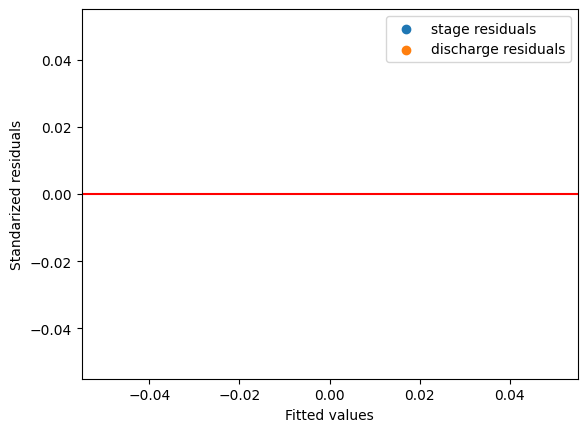

In [83]:
residuals = y_real - y_predictions
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[0] for i in y_real])
residual_stage = np.array([i[0] for i in residuals])

y_real_discharge = np.array([i[1] for i in y_real])
residual_discharge = np.array([i[1] for i in residuals])

plt.scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
plt.scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel("Fitted values")
plt.ylabel("Standarized residuals")

plt.legend()
plt.show()

/tmp/ipykernel_95034/3505247562.py:4: RuntimeWarning: divide by zero encountered in divide
  figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')


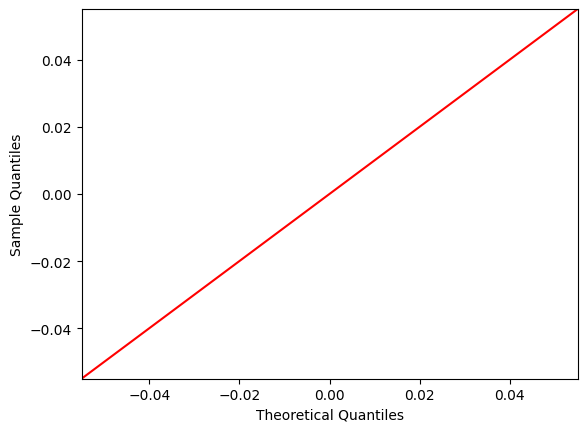

In [84]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

/tmp/ipykernel_95034/1192211388.py:1: RuntimeWarning: divide by zero encountered in divide
  figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')


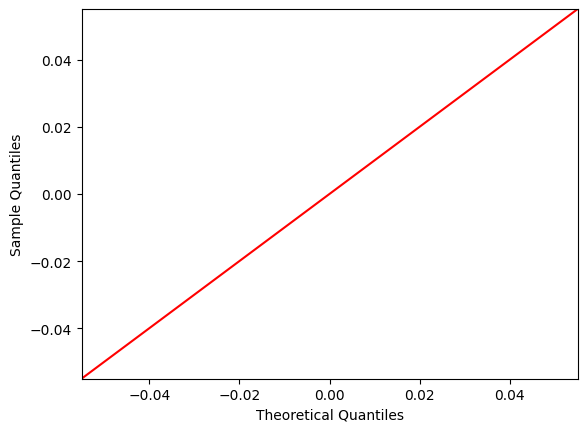

In [85]:
figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')
plt.show()

In [86]:
import seaborn as sns

#sns.histplot(residuals, kde=True, bins = 10)

In [87]:
stat, pval = normal_ad(residual_stage)
print("p-value:", pval)

if pval<0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")

p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [88]:
stat, pval = normal_ad(residual_discharge)
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


## Visualize layers

In [89]:
layer_outputs = [layer.output for layer in best_model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=best_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [90]:
activations = activation_model.predict(test_ds.take(1)) 

1/1 [==============================] - 0s 189ms/step


2022-10-19 01:22:56.544975: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


conv2d_25
max_pooling2d_10
conv2d_26
max_pooling2d_11
conv2d_27
conv2d_28
conv2d_29
average_pooling2d_5
flatten_4


/tmp/ipykernel_95034/1031377702.py:24: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


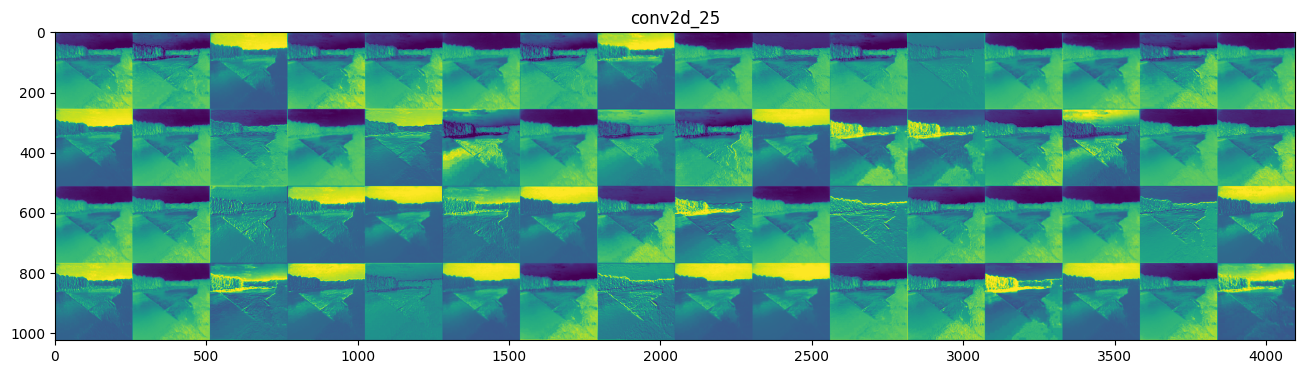

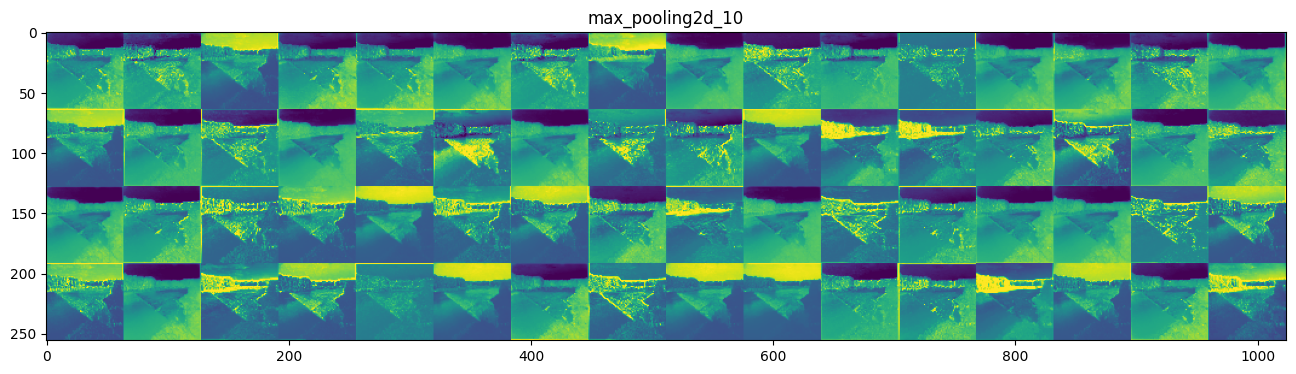

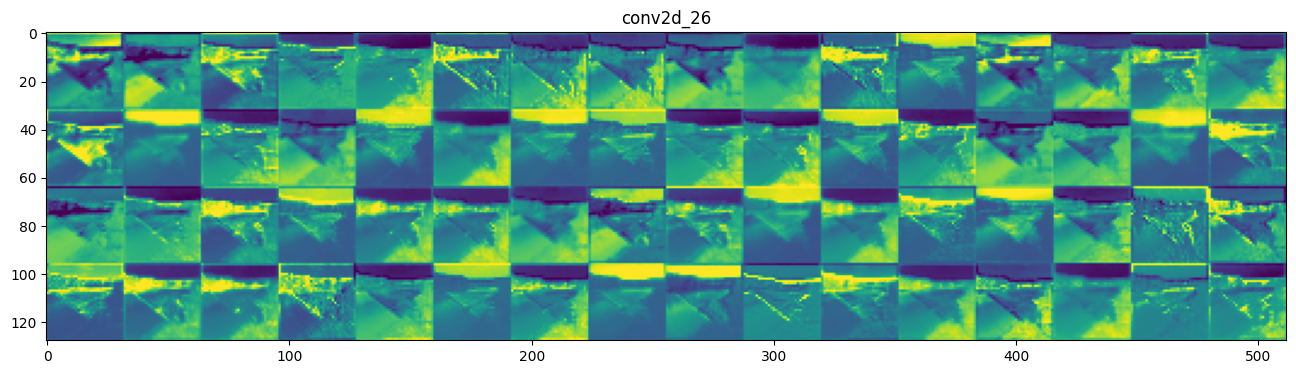

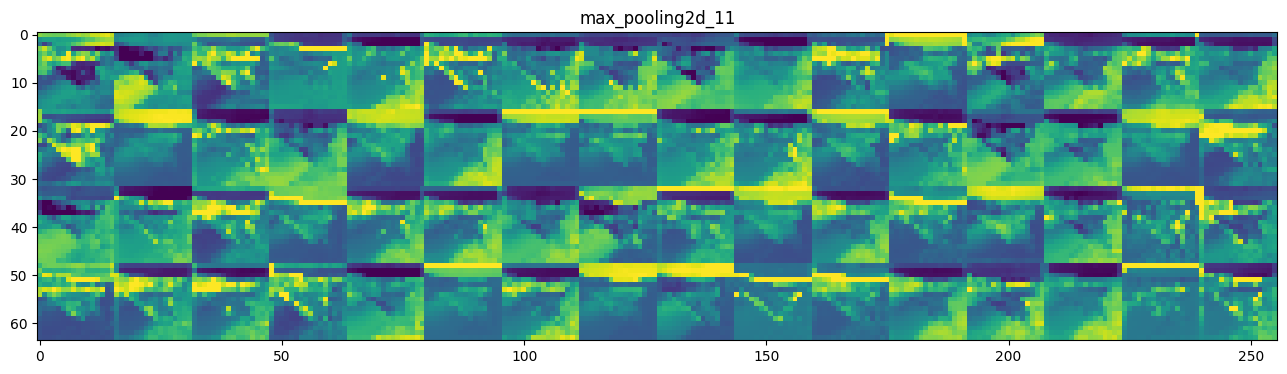

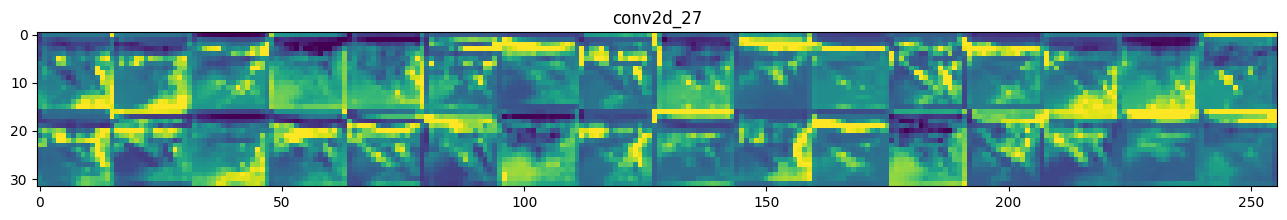

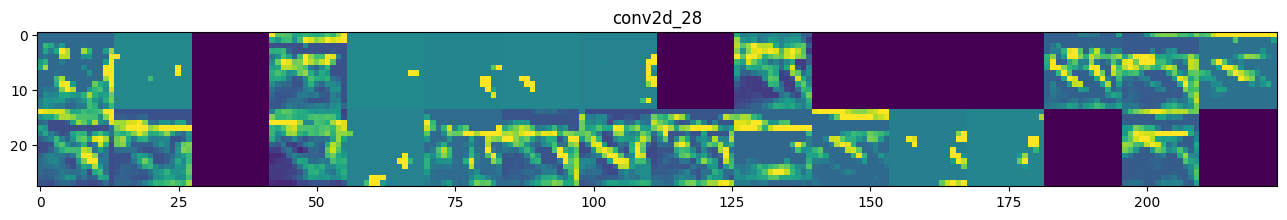

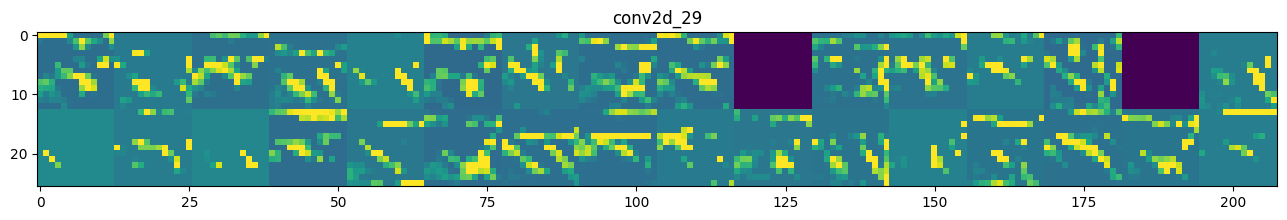

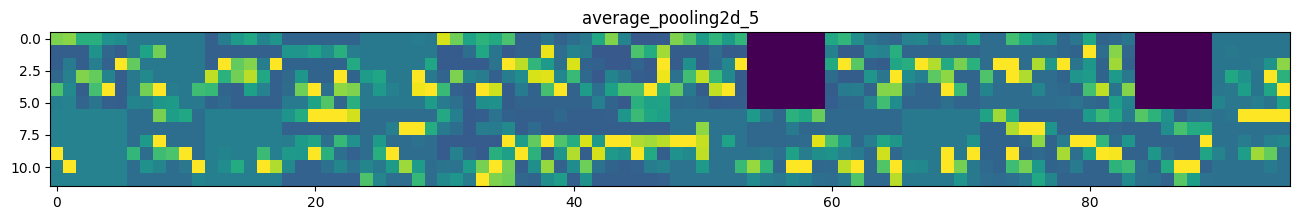

In [91]:
import matplotlib.pyplot as plt

layer_names = []
for layer in best_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    print(layer_name)
    if "flatten" in layer_name or "dense" in layer_name: break

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')